In [1]:
import numpy as np
import scipy.linalg as scp
import matplotlib.pyplot as plt
import torch
import time

In [2]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.config import Config

# LQR

In [3]:
G = - torch.eye(4)
R = - torch.eye(2) * 0.1

T = 1_000

In [4]:
env = RobotWorld()
controller = Lqr(env.A, env.B, G, R)

states = torch.zeros([T, 4])
actions = torch.zeros([T, 2])

s = env.reset()
for i in range(0, T):
    u = controller.pi(s)
    sp = env.step(u)

    states[i] = s
    actions[i] = u

    s = sp[::]

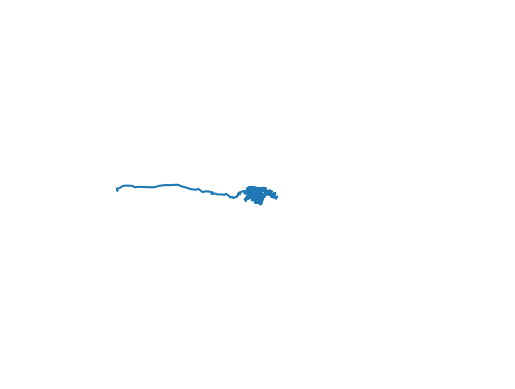

In [5]:
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

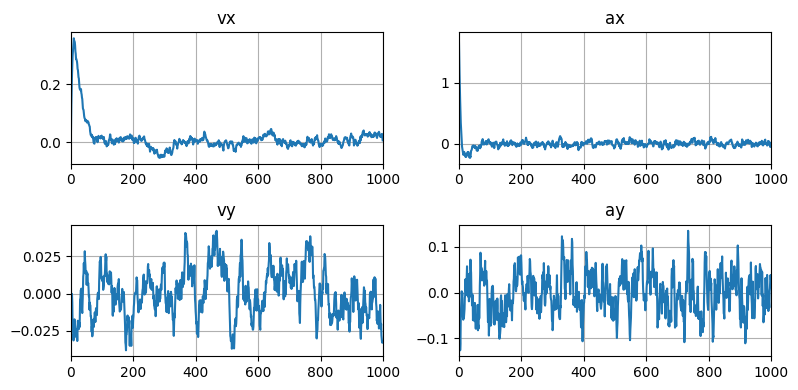

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

# Discounted LQR

In [7]:
G = - torch.eye(4)
R = - torch.eye(2) * 0.1

gamma = torch.tensor(0.99)

T = 1_000

In [8]:
env = RobotWorld()
controller = Lqr(
    A=torch.sqrt(gamma) * env.A,
    B=torch.sqrt(gamma) * env.B,
    G=G,
    R=R
)

states = torch.zeros([T, 4])
actions = torch.zeros([T, 2])

s = env.reset()
for i in range(0, T):
    u = controller.pi(s)
    sp = env.step(u)

    states[i] = s
    actions[i] = u

    s = sp[::]

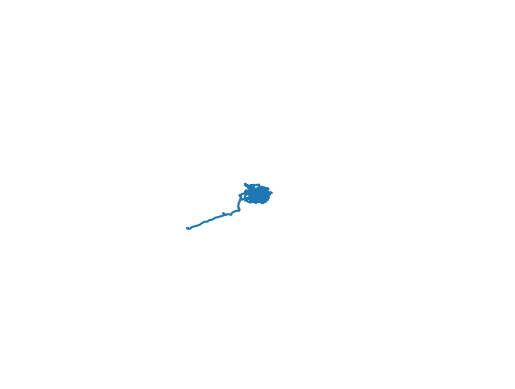

In [9]:
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

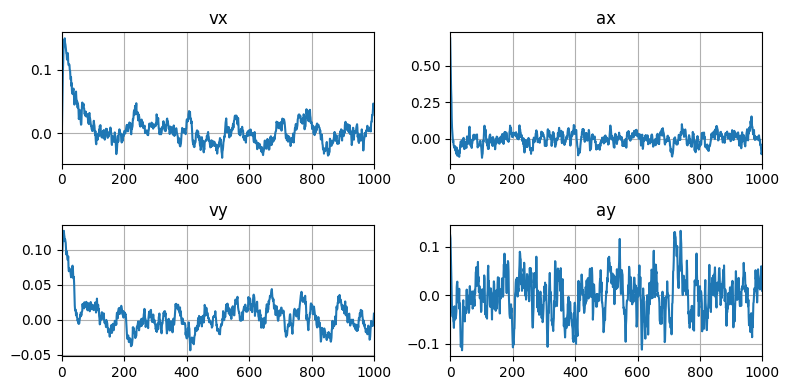

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

# Exact DPGPD - Unconstrained

In [11]:
from scipy.linalg import solve_discrete_lyapunov

In [20]:
def get_p(A, B, G, R, K, gamma):
    """
    M = G + K.T @ R @ K
    L = torch.sqrt(gamma) * (A + B @ K)
    P = solve_discrete_lyapunov(L, M)
    """

    ds = A.shape[0]
    X = torch.eye(ds ** 2) - gamma * torch.kron((A + B @ K).T, (A + B @ K).T )
    b = (G + K.T @ R @ K).flatten()
    P = (torch.inverse(X) @ b).reshape(ds, ds)
    return P

def get_k(A, B, R, K, P, I_eta, gamma):
    H_odiag = gamma * B.T @ P @ A
    H_diag = R + gamma * B.T @ P @ B
    return - torch.inverse(2 * H_diag + 2 * R - I_eta) @ (2 * H_odiag + I_eta @ K)

def get_v(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()


In [21]:
ds = 4
da = 2

eta = torch.tensor(0.1).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()

G1 = - torch.eye(ds).double()
R1 = - torch.eye(da).double() * (tau / 2)
G2 = - torch.tensor([
    [.001, 0, 0, 0],
    [0, .001, 0, 0],
    [0, 0, .001, 0],
    [0, 0, 0, .001]
])
R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double()

I_eta = torch.eye(da).double() * (1 / eta)

In [22]:
K = torch.randn(da, ds).double() * 0.1
loss_primal, loss_dual = [], []
for i in range(1_000):
    P_primal = get_p(env.A, env.B, G1, R1, K, gamma)
    P_dual = get_p(env.A, env.B, G2, R2, K, gamma)

    loss_primal.append(get_v(env, P_primal))
    loss_dual.append(get_v(env, P_dual))

    K = get_k(env.A, env.B, R1, K, P_primal, I_eta, gamma)

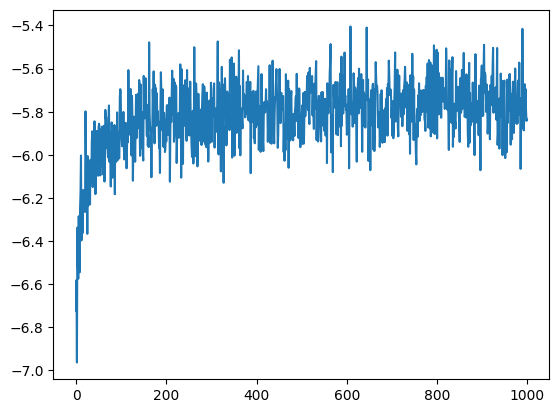

In [23]:
plt.plot(loss_primal)
plt.show()

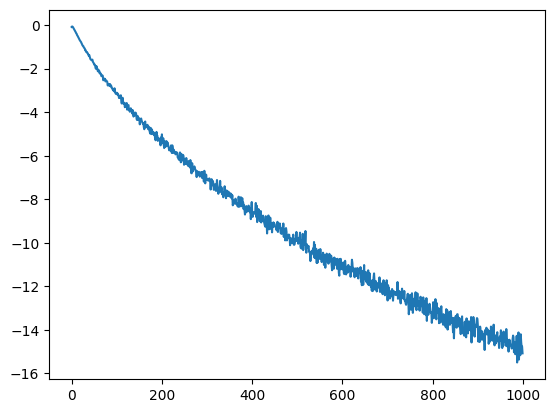

In [24]:
plt.plot(loss_dual)
plt.show()

In [25]:
env = RobotWorld()

states = torch.zeros([T, 4])
actions = torch.zeros([T, 2])

s = env.reset()
for i in range(0, T):
    u = s @ K.T
    sp = env.step(u)

    states[i] = s
    actions[i] = u

    s = sp[::]

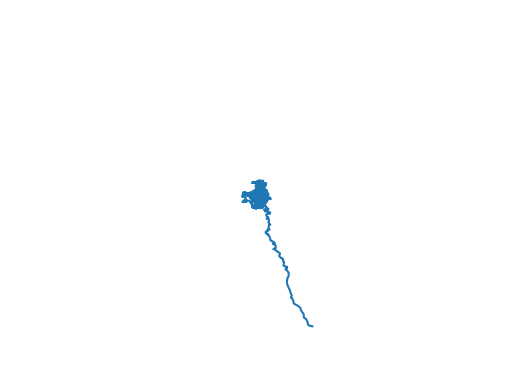

In [26]:
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

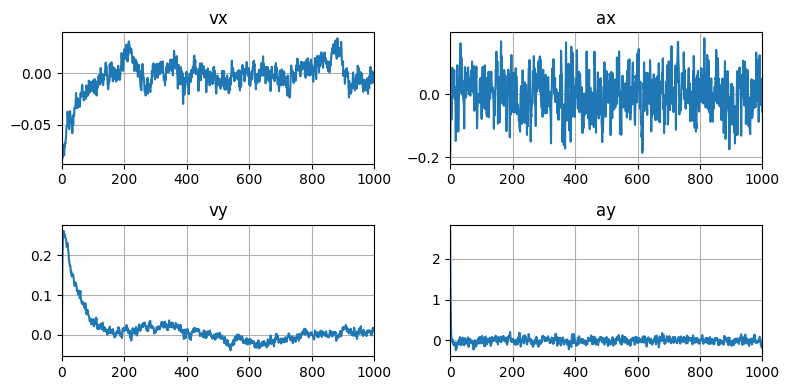

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

# Exact DPGPD - Constrained

In [29]:
def update_lq(G1, G2, R1, R2, lmbda):
    return G1 + lmbda * G2, R1 + lmbda * R2

def get_p(A, B, G, R, K, gamma):
    ds = A.shape[0]
    X = torch.eye(ds ** 2) - gamma * torch.kron((A + B @ K).T, (A + B @ K).T )
    b = (G + K.T @ R @ K).flatten()
    P = (torch.inverse(X) @ b).reshape(ds, ds)
    return P

def primal_update(A, B, R, K, P, I_eta, gamma):
    H_odiag = gamma * B.T @ P @ A
    H_diag = R + gamma * B.T @ P @ B
    return - torch.inverse(2 * H_diag + 2 * R - I_eta) @ (2 * H_odiag + I_eta @ K)

def get_v(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()

def dual_update(env, P, b, lmbda, eta, tau):
    v = get_v(env, P)
    return torch.clamp(lmbda - eta * (v - b + tau * lmbda), min=0)

In [30]:
ds = 4
da = 2

eta = torch.tensor(0.01).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()
b = torch.tensor(-4).double()

G1 = - torch.eye(ds).double()
R1 = - torch.eye(da).double() * (tau / 2)
G2 = - torch.tensor([
    [.001, 0, 0, 0],
    [0, .001, 0, 0],
    [0, 0, .001, 0],
    [0, 0, 0, .001]
])
R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double()

I_eta = torch.eye(da).double() * (1 / eta)

In [34]:
K = torch.randn(da, ds).double() * 0.1
lmbda = 0.1
loss_primal, loss_dual = [], []
for _ in range(2_000):
    Gl, Rl = update_lq(G1, G2, R1, R2, lmbda)

    P_primal = get_p(env.A, env.B, Gl, Rl, K, gamma)
    P_primal_unconstrained = get_p(env.A, env.B, G1, R1, K, gamma)
    P_dual = get_p(env.A, env.B, G2, R2, K, gamma)

    loss_primal.append(get_v(env, P_primal_unconstrained))
    loss_dual.append(get_v(env, P_dual))

    # Primal update
    K = primal_update(env.A, env.B, Rl, K, P_primal, I_eta, gamma)

    # Dual update
    lmbda = dual_update(env, P_dual, b, lmbda, eta, tau)

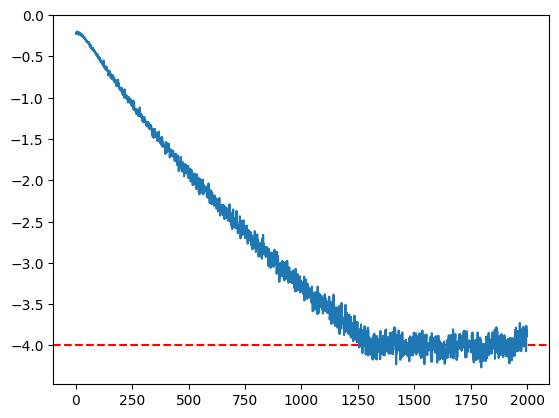

In [35]:
plt.axhline(y=b, color='r', linestyle='--')
plt.plot(loss_dual)
plt.show()

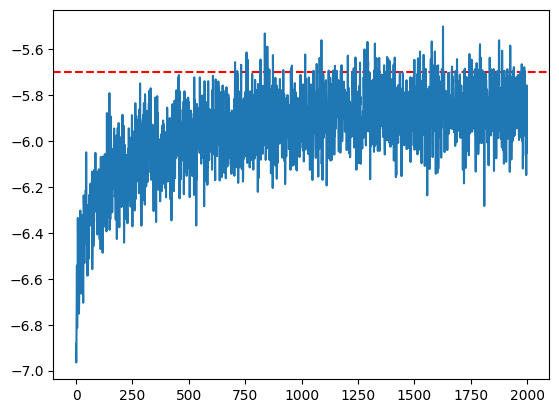

In [36]:
plt.axhline(y=-5.7, color='r', linestyle='--')
plt.plot(loss_primal)
plt.show()

In [37]:
env = RobotWorld()

states = torch.zeros([T, 4])
actions = torch.zeros([T, 2])

s = env.reset()
for i in range(0, T):
    u = s @ K.T
    sp = env.step(u)

    states[i] = s
    actions[i] = u

    s = sp[::]

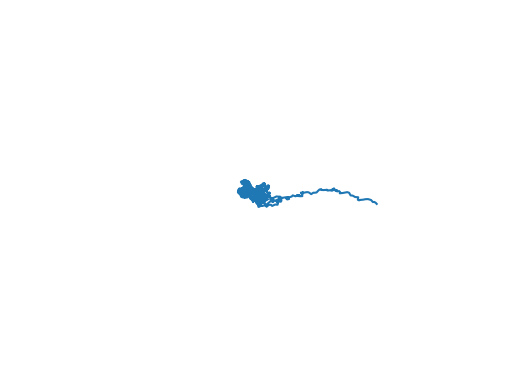

In [38]:
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

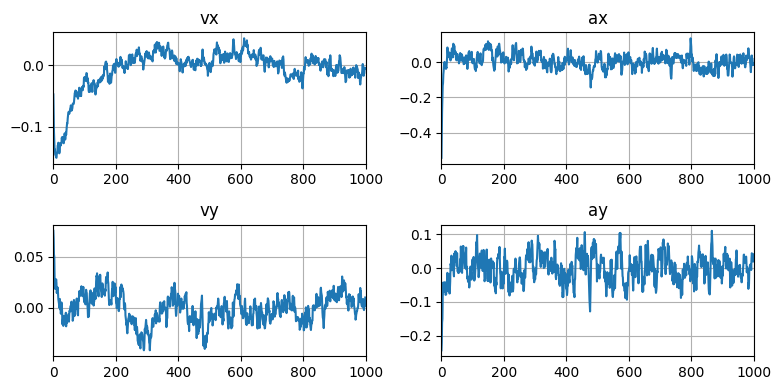

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[8, 4])

axes[0, 0].plot(states[:, 2])
axes[0, 0].grid()
axes[0, 0].set_title("vx")
axes[0, 0].set_xlim(0, T)

axes[1, 0].plot(states[:, 3])
axes[1, 0].grid()
axes[1, 0].set_title("vy")
axes[1, 0].set_xlim(0, T)

axes[0, 1].plot(actions[:, 0])
axes[0, 1].grid()
axes[0, 1].set_title("ax")
axes[0, 1].set_xlim(0, T)

axes[1, 1].plot(actions[:, 1])
axes[1, 1].grid()
axes[1, 1].set_title("ay")
axes[1, 1].set_xlim(0, T)

plt.tight_layout()
plt.show()

In [40]:
loss_primal, loss_dual = [], []
P_primal = get_p(env.A, env.B, G1, R1, K, gamma)
P_dual = get_p(env.A, env.B, G2, R2, K, gamma)
for _ in range(1_000):
    loss_primal.append(get_v(env, P_primal))
    loss_dual.append(get_v(env, P_dual))

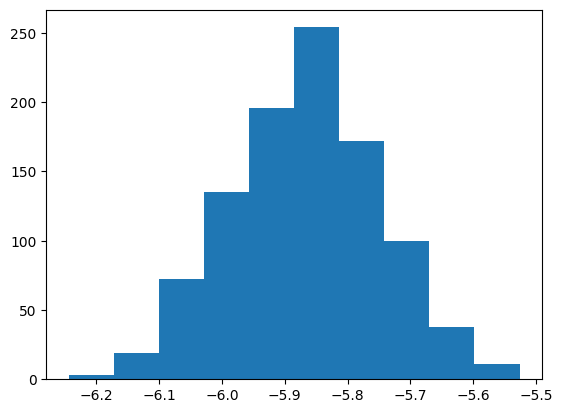

In [41]:
plt.hist(loss_primal)
plt.show()

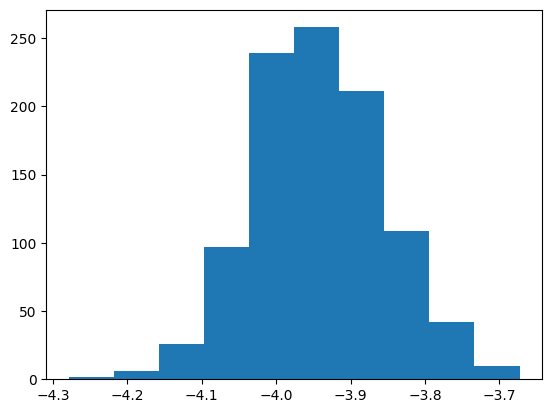

In [42]:
plt.hist(loss_dual)
plt.show()

# Unconstrained D-PG-PD / Exact Q

In [43]:
def get_estimator_weight(ds, da, theta, tau, eta, alpha):
    W_1 = np.zeros((da, ds))
    for i in range(da):
        for j in range(ds):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            s_idx[j] = -1
            a_idx[i] = 1
            s_a_idx = torch.concat([s_idx, a_idx])
            mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
            w = (theta * mask).sum()
            W_1[i, j] = w

    W_2 = torch.zeros((da, da))
    for i in range(da):
        for j in range(da):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            a_idx[i] = 1
            a_idx[j] = -1
            s_a_idx = torch.concat([s_idx, a_idx])

            if i == j:
                mask = torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1)
                w = (theta * mask).sum()
                W_2[i, j] = 2 * w * alpha
            else:
                mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
                w = (theta * mask).sum()
                W_2[i, j] = w
    K = - torch.inverse(W_2 - (tau + 1 / eta) * torch.eye(da)) @ W_1
    return K.double()


In [44]:
def get_v(s, P):
    return s @ P @ s

def estimate_primal_loss(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()

def get_Q(s, a, H):
    return torch.cat((s, a), dim=0) @ H @ torch.cat((s, a), dim=0) 

def get_p(A, B, G, R, K, gamma):
    ds = A.shape[0]
    X = torch.eye(ds ** 2) - gamma * torch.kron((A + B @ K).T, (A + B @ K).T )
    b = (G + K.T @ R @ K).flatten()
    P = (torch.inverse(X) @ b).reshape(ds, ds)
    return P

def get_h(A, B, P, G, R):
    H_11 = G + gamma * A.T @ P @ A
    H_12 = gamma * A.T @ P @ B
    H_21 = gamma * B.T @ P @ A
    H_22 = R + gamma * B.T @ P @ B

    top = torch.cat((H_11, H_12), dim=1)
    bot = torch.cat((H_21, H_22), dim=1)

    H = torch.cat((top, bot), dim=0)
    return H

In [45]:
def get_initial_point():
    rng = np.random.default_rng()

    s = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    a = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    return s, a

In [48]:
def policy_evaluation(env, K, gamma, eta, alpha, N, theta, G, R):
    X, y = torch.zeros((N, 36)), torch.zeros(N)
    P = get_p(env.A, env.B, G, R, K, gamma)
    H = get_h(env.A, env.B, P, G, R)
    for n in range(N):
        s, a = get_initial_point()
        s_a = torch.concat([s, a])
        b = torch.flatten(torch.ger(s_a, s_a) + torch.diag((alpha - 1) * s_a**2))

        a_pi = s @ K.T
        q = get_Q(s, a, H)
        l = q + (1 / eta) * a_pi @ a

        X[n] = b
        y[n] = l

    theta = torch.linalg.lstsq(X, y, driver='gelsd').solution

    #y_pred = torch.matmul(X, theta)
    #mse = torch.sum((y_pred - y)**2) / N
    #print(f"MSE: {mse} - MR: {(y_pred - y).mean()} - Means: {y_pred.mean()} / {y.mean()}")

    return theta

In [49]:
ds = 4
da = 2

eta = torch.tensor(0.1).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()

G = - torch.eye(ds).double()
R = - torch.eye(da).double() * (tau / 2)

N = 1_000
E = 10
alpha = 1.0

In [50]:
losses = []

env = RobotWorld()
theta = torch.rand((ds + da)**2) * 0.001
K = get_estimator_weight(ds, da, theta, tau, eta, alpha)

for e in range(E):
    theta = policy_evaluation(env, K, gamma, eta, alpha, N, theta, G, R)
    K = get_estimator_weight(ds, da, theta, tau, eta, alpha)

    P = get_p(env.A, env.B, G, R, K, gamma)
    loss = estimate_primal_loss(env, P)
    losses.append(loss)

    print(f"Episode {e}/{E} - Return {loss} \r", end='')

In [51]:
s = env.reset()
states = np.zeros((T, 4))
actions = np.zeros((T, 2))
ret = 0
for t in range(T):
    a = s @ K.T
    sp = env.step(a)

    states[t] = s.detach().numpy()
    actions[t] = a.detach().numpy()

    s = sp

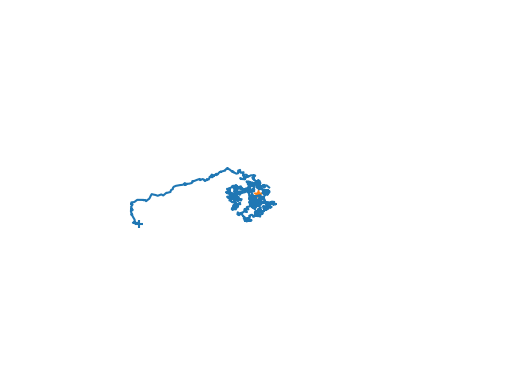

In [52]:
plt.scatter(states[0, 0], states[0, 1], marker='+')
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

# Unconstrained D-PG-PD / Sample-based Q

In [53]:
def get_estimator_weight(ds, da, theta, tau, eta, alpha):
    W_1 = np.zeros((da, ds))
    for i in range(da):
        for j in range(ds):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            s_idx[j] = -1
            a_idx[i] = 1
            s_a_idx = torch.concat([s_idx, a_idx])
            mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
            w = (theta * mask).sum()
            W_1[i, j] = w

    W_2 = torch.zeros((da, da))
    for i in range(da):
        for j in range(da):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            a_idx[i] = 1
            a_idx[j] = -1
            s_a_idx = torch.concat([s_idx, a_idx])

            if i == j:
                mask = torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1)
                w = (theta * mask).sum()
                W_2[i, j] = 2 * w * alpha
            else:
                mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
                w = (theta * mask).sum()
                W_2[i, j] = w
    K = - torch.inverse(W_2 - (tau + 1 / eta) * torch.eye(da)) @ W_1
    return K.double()


In [54]:
def estimate_primal_loss(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()

In [55]:
def rollout(s, a, K, env, T, gamma, G, R):
    env.s = s
    sp = env.step(a)
    r = s @ G @ s + a @ R @ a
    s = sp

    q_hat = r
    for i in range(1, T):
        a = s @ K.T
        sp = env.step(a)

        r = s @ G @ s + a @ R @ a
        q_hat += (gamma**i) * r

        s = sp
    return q_hat

In [56]:
def get_initial_point():
    rng = np.random.default_rng()

    s = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    a = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    return s, a

In [59]:
def policy_evaluation(env, K, T, gamma, eta, alpha, N, theta, G, R):
    X, y = torch.zeros((N, 36)), torch.zeros(N)
    for k in range(N):
        s, a = get_initial_point()
        s_a = torch.concat([s, a])
        b = torch.flatten(torch.ger(s_a, s_a) + torch.diag((alpha - 1) * s_a**2))

        a_pi = s @ K.T
        q = rollout(s, a, K, env, T, gamma, G, R)
        l = q + (1 / eta) * a_pi @ a

        X[k] = b
        y[k] = l

    theta = torch.linalg.lstsq(X, y, driver='gelsd').solution

    #y_pred = torch.matmul(X, theta)
    #mse = torch.sum((y_pred - y)**2) / N
    #print(f"MSE: {mse} - MR: {(y_pred - y).mean()} - Means: {y_pred.mean()} / {y.mean()}")

    return theta

In [60]:
ds = 4
da = 2

eta = torch.tensor(0.1).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()

G = - torch.eye(ds).double()
R = - torch.eye(da).double() * (tau / 2)

T = 100
N = 1_000
E = 10
alpha = 1.0

In [61]:
losses = []

env = RobotWorld()
theta = torch.rand((ds + da)**2) * 0.001
K = get_estimator_weight(ds, da, theta, tau, eta, alpha)

for e in range(E):
    theta = policy_evaluation(env, K, T, gamma, eta, alpha, N, theta, G, R)
    K = get_estimator_weight(ds, da, theta, tau, eta, alpha)

    P = get_p(env.A, env.B, G, R, K, gamma)
    loss = estimate_primal_loss(env, P)
    losses.append(loss)

    print(f"Episode {e}/{E} - Return {loss} \r", end='')

In [65]:
s = env.reset()
states = np.zeros((1_000, 4))
actions = np.zeros((1_000, 2))
ret = 0
for t in range(1_000):
    a = s @ K.T
    sp = env.step(a)

    states[t] = s.detach().numpy()
    actions[t] = a.detach().numpy()

    s = sp

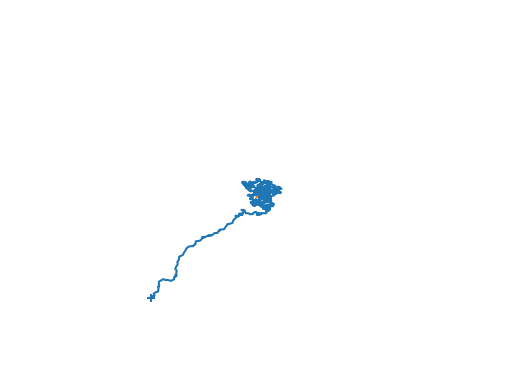

In [66]:
plt.scatter(states[0, 0], states[0, 1], marker='+')
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

# Constrained D-PG-PD / Exact Q

In [67]:
def update_lq(G1, G2, R1, R2, lmbda):
    return G1 + lmbda * G2, R1 + lmbda * R2

def get_v(s, P):
    return s @ P @ s

def estimate_loss(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()

def get_Q(s, a, H):
    return torch.cat((s, a), dim=0) @ H @ torch.cat((s, a), dim=0) 

def get_p(A, B, G, R, K, gamma):
    ds = A.shape[0]
    X = torch.eye(ds ** 2) - gamma * torch.kron((A + B @ K).T, (A + B @ K).T )
    b = (G + K.T @ R @ K).flatten()
    P = (torch.inverse(X) @ b).reshape(ds, ds)
    return P

def get_h(A, B, P, G, R):
    H_11 = G + gamma * A.T @ P @ A
    H_12 = gamma * A.T @ P @ B
    H_21 = gamma * B.T @ P @ A
    H_22 = R + gamma * B.T @ P @ B

    top = torch.cat((H_11, H_12), dim=1)
    bot = torch.cat((H_21, H_22), dim=1)

    H = torch.cat((top, bot), dim=0)
    return H

In [68]:
def primal_update(ds, da, theta, tau, eta, alpha):
    W_1 = np.zeros((da, ds))
    for i in range(da):
        for j in range(ds):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            s_idx[j] = -1
            a_idx[i] = 1
            s_a_idx = torch.concat([s_idx, a_idx])
            mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
            w = (theta * mask).sum()
            W_1[i, j] = w

    W_2 = torch.zeros((da, da))
    for i in range(da):
        for j in range(da):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            a_idx[i] = 1
            a_idx[j] = -1
            s_a_idx = torch.concat([s_idx, a_idx])

            if i == j:
                mask = torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1)
                w = (theta * mask).sum()
                W_2[i, j] = 2 * w * alpha
            else:
                mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
                w = (theta * mask).sum()
                W_2[i, j] = w
    K = - torch.inverse(W_2 - (tau + 1 / eta) * torch.eye(da)) @ W_1
    return K.double()

def dual_update(env, P, b, lmbda, eta, tau):
    v = estimate_loss(env, P)
    return torch.clamp(lmbda - eta * (v - b + tau * lmbda), min=0)


In [69]:
def get_initial_point():
    rng = np.random.default_rng()

    s = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    a = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    return s, a

In [70]:
def policy_evaluation(env, K, gamma, eta, alpha, N, theta, G, R):
    X, y = torch.zeros((N, 36)), torch.zeros(N)
    P = get_p(env.A, env.B, G, R, K, gamma)
    H = get_h(env.A, env.B, P, G, R)
    for n in range(N):
        s, a = get_initial_point()
        s_a = torch.concat([s, a])
        b = torch.flatten(torch.ger(s_a, s_a) + torch.diag((alpha - 1) * s_a**2))

        a_pi = s @ K.T
        q = get_Q(s, a, H)
        l = q + (1 / eta) * a_pi @ a

        X[n] = b
        y[n] = l

    theta = torch.linalg.lstsq(X, y, driver='gelsd').solution

    #y_pred = torch.matmul(X, theta)
    #mse = torch.sum((y_pred - y)**2) / N
    #print(f"MSE: {mse} - MR: {(y_pred - y).mean()} - Means: {y_pred.mean()} / {y.mean()}")

    return theta

In [76]:
ds = 4
da = 2

eta = torch.tensor(0.01).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()
b = torch.tensor(-4).double()

G1 = - torch.eye(ds).double()
R1 = - torch.eye(da).double() * (tau / 2)
G2 = - torch.tensor([
    [.001, 0, 0, 0],
    [0, .001, 0, 0],
    [0, 0, .001, 0],
    [0, 0, 0, .001]
])
R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double()

N = 1_000
E = 2_000
alpha = 1.0

In [77]:
losses_primal, losses_dual = [], []

env = RobotWorld()
theta = torch.rand((ds + da)**2) * 0.001
K = primal_update(ds, da, theta, tau, eta, alpha)
lmbda = 0.1

for e in range(E):
    Gl, Rl = update_lq(G1, G2, R1, R2, lmbda)

    P_primal = get_p(env.A, env.B, Gl, Rl, K, gamma)
    P_primal_unconstrained = get_p(env.A, env.B, G1, R1, K, gamma)
    P_dual = get_p(env.A, env.B, G2, R2, K, gamma)

    loss_primal = estimate_loss(env, P_primal_unconstrained)
    loss_dual = estimate_loss(env, P_dual)

    losses_primal.append(loss_primal)
    losses_dual.append(loss_dual)

    theta = policy_evaluation(env, K, gamma, eta, alpha, N, theta, Gl, Rl)
    K = primal_update(ds, da, theta, tau, eta, alpha)
    lmbda = dual_update(env, P_dual, b, lmbda, eta, tau)

    print(f'Episode {e}/{E} - Return {loss_primal} - Constrain {loss_dual} \r', end='')

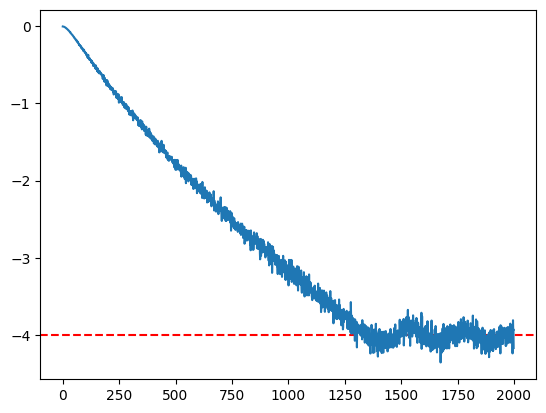

In [78]:
plt.axhline(y=b, color='r', linestyle='--')
plt.plot(losses_dual)
plt.show()

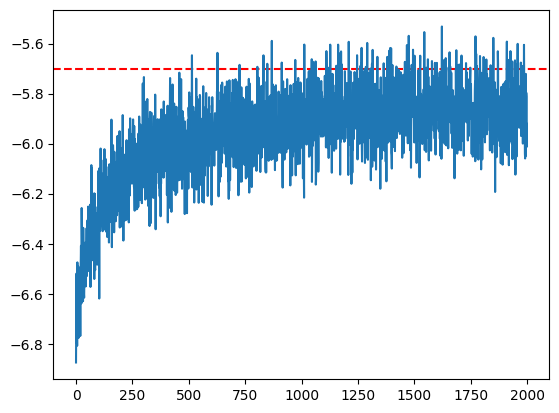

In [79]:
plt.axhline(y=-5.7, color='r', linestyle='--')
plt.plot(losses_primal)
plt.show()

In [80]:
iterations = 1_000

s = env.reset()
states = np.zeros((iterations, 4))
actions = np.zeros((iterations, 2))
ret = 0
for t in range(iterations):
    a = s @ K.T
    sp = env.step(a)

    states[t] = s.detach().numpy()
    actions[t] = a.detach().numpy()

    s = sp

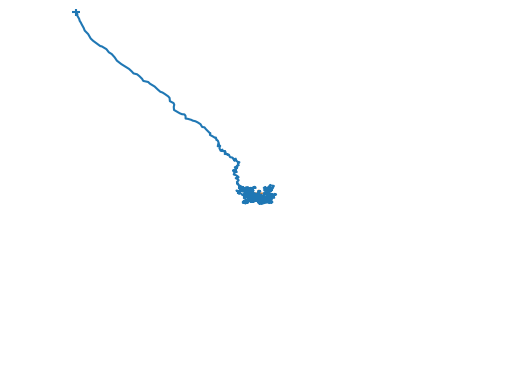

In [81]:
plt.scatter(states[0, 0], states[0, 1], marker='+')
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()

# Constrained D-PG-PD / Sample-based Q

In [82]:
def update_lq(G1, G2, R1, R2, lmbda):
    return G1 + lmbda * G2, R1 + lmbda * R2

def estimate_loss(env, P):
    vs = 0
    for _ in range(1_000):
        s = env.reset()
        vs += s @ P @ s
    return (vs / 1_000).detach().item()

def get_v(env, K, T, gamma, G, R):
    vs = 0
    for _ in range(100):
        s = env.reset()
        v = rollout_v(s, K, env, T, gamma, G, R)
        vs += v
    return (vs / 100).detach().item()

def rollout_q(s, a, K, env, T, gamma, G, R):
    env.s = s
    sp = env.step(a)
    r = s @ G @ s + a @ R @ a
    s = sp

    q_hat = r
    for i in range(1, T):
        a = s @ K.T
        sp = env.step(a)

        r = s @ G @ s + a @ R @ a
        q_hat += (gamma**i) * r

        s = sp
    return q_hat

def rollout_v(s, K, env, T, gamma, G, R):
    env.s = s
    v_hat = 0
    for i in range(0, T):
        a = s @ K.T
        sp = env.step(a)

        r = s @ G @ s + a @ R @ a
        v_hat += (gamma**i) * r

        s = sp
    return v_hat

In [83]:
def primal_update(ds, da, theta, tau, eta, alpha):
    W_1 = np.zeros((da, ds))
    for i in range(da):
        for j in range(ds):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            s_idx[j] = -1
            a_idx[i] = 1
            s_a_idx = torch.concat([s_idx, a_idx])
            mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
            w = (theta * mask).sum()
            W_1[i, j] = w

    W_2 = torch.zeros((da, da))
    for i in range(da):
        for j in range(da):
            s_idx, a_idx = torch.zeros(ds), torch.zeros(da)
            a_idx[i] = 1
            a_idx[j] = -1
            s_a_idx = torch.concat([s_idx, a_idx])

            if i == j:
                mask = torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1)
                w = (theta * mask).sum()
                W_2[i, j] = 2 * w * alpha
            else:
                mask = - torch.cartesian_prod(s_a_idx, s_a_idx).prod(dim=1).clip(-1, 0) 
                w = (theta * mask).sum()
                W_2[i, j] = w
    K = - torch.inverse(W_2 - (tau + 1 / eta) * torch.eye(da)) @ W_1
    return K.double()

def dual_update(env, K, b, lmbda, eta, tau, T, G, R, gamma):
    v = get_v(env, K, T, gamma, G, R)
    return torch.clamp(lmbda - eta * (v - b + tau * lmbda), min=0)


In [84]:
def get_initial_point():
    rng = np.random.default_rng()

    s = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    a = torch.tensor([
        rng.uniform(-5, 5),
        rng.uniform(-5, 5),
    ]).double()

    return s, a

In [85]:
def policy_evaluation(env, K, gamma, eta, alpha, N, theta, G, R, T):
    X, y = torch.zeros((N, 36)), torch.zeros(N)
    for n in range(N):
        s, a = get_initial_point()
        s_a = torch.concat([s, a])
        b = torch.flatten(torch.ger(s_a, s_a) + torch.diag((alpha - 1) * s_a**2))

        a_pi = s @ K.T
        q = rollout_q(s, a, K, env, T, gamma, G, R)
        l = q + (1 / eta) * a_pi @ a

        X[n] = b
        y[n] = l

    theta = torch.linalg.lstsq(X, y, driver='gelsd').solution

    #y_pred = torch.matmul(X, theta)
    #mse = torch.sum((y_pred - y)**2) / N
    #print(f"MSE: {mse} - MR: {(y_pred - y).mean()} - Means: {y_pred.mean()} / {y.mean()}")

    return theta

In [86]:
ds = 4
da = 2

eta = torch.tensor(0.01).double()
tau = torch.tensor(0.001).double()
gamma = torch.tensor(0.9).double()
b = torch.tensor(-4).double()

G1 = - torch.eye(ds).double()
R1 = - torch.eye(da).double() * (tau / 2)
G2 = - torch.tensor([
    [.001, 0, 0, 0],
    [0, .001, 0, 0],
    [0, 0, .001, 0],
    [0, 0, 0, .001]
]).double()
R2 = - torch.tensor([
    [1., 0],
    [0, 1.],
]).double()

T = 100
N = 100
E = 2_000
alpha = 1.0

In [87]:
losses_primal, losses_dual = [], []

env = RobotWorld()
theta = torch.rand((ds + da)**2) * 0.001
K = primal_update(ds, da, theta, tau, eta, alpha)
lmbda = 0.1

for e in range(E):
    Gl, Rl = update_lq(G1, G2, R1, R2, lmbda)

    P_primal_unconstrained = get_p(env.A, env.B, G1, R1, K, gamma)
    P_dual = get_p(env.A, env.B, G2, R2, K, gamma)

    loss_primal = estimate_loss(env, P_primal_unconstrained)
    loss_dual = estimate_loss(env, P_dual)

    losses_primal.append(loss_primal)
    losses_dual.append(loss_dual)

    theta = policy_evaluation(env, K, gamma, eta, alpha, N, theta, Gl, Rl, T)
    K = primal_update(ds, da, theta, tau, eta, alpha)
    lmbda = dual_update(env, K, b, lmbda, eta, tau, T, G2, R2, gamma)

    print(f'Episode {e}/{E} - Return {loss_primal} - Constrain {loss_dual} \r', end='', flush=True)

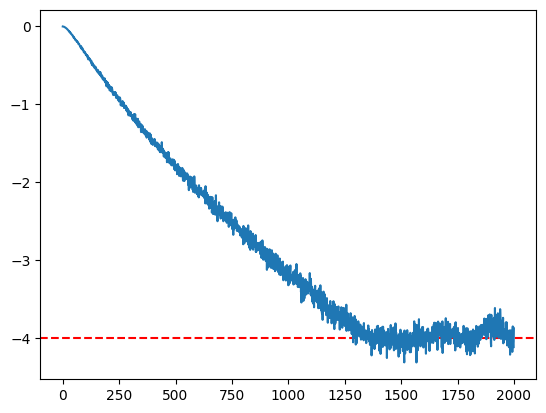

In [88]:
plt.axhline(y=b, color='r', linestyle='--')
plt.plot(losses_dual)
plt.show()

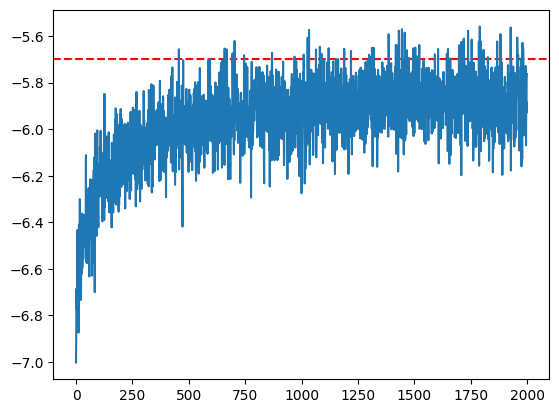

In [90]:
plt.axhline(y=-5.7, color='r', linestyle='--')
plt.plot(losses_primal)
plt.show()

In [91]:
iterations = 1_000

s = env.reset()
states = np.zeros((iterations, 4))
actions = np.zeros((iterations, 2))
ret = 0
for t in range(iterations):
    a = s @ K.T
    sp = env.step(a)

    states[t] = s.detach().numpy()
    actions[t] = a.detach().numpy()

    s = sp

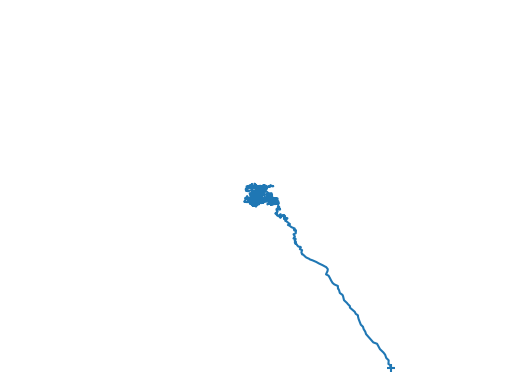

In [92]:
plt.scatter(states[0, 0], states[0, 1], marker='+')
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axis('off')
plt.show()